In [1]:
import zipfile as zp
import pandas as pd
import numpy as np
# from pypac import PACSession as Session #or use requests below if non-ONS
#from requests import Session
from io import BytesIO
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import LoadData as dataLoader
%matplotlib notebook

###  Read in files


In [ ]:
# Path to zip files
path = "/Users/lb8075/Loneliness_Data_challenge/Loneliness_notebook/Data/"

In [ ]:
print (path[:-5])
print (path[:-25])

First lets load all the data... do this just once!

In [2]:
proc_data, proc_data_dict =dataLoader.loadFinalData('../Loneliness')
codes=dataLoader.loadProccessedData('../Loneliness')
drugs_list = dataLoader.loadDrugsList('../Loneliness')
msoa_data, msoa_data_dict = dataLoader.loadmsoaData('../Loneliness')

In [13]:
mData = dataLoader.mergedDataStreams(proc_data,codes)
mData.reset_index(drop=False, inplace=True)
mData.groupby(['PCT','Postcode','Year']).aggregate(np.mean)[['NUMBER_OF_PATIENTS','loneliness_zscore']].head(10)

NUMBER_OF_PATIENTS  loneliness_zscore
PCT Postcode Year                                       
00C DL1 3RT  2016         3842.750000           0.343652
             2017         9748.166667           0.359031
             2018        11859.166667           0.356975
    DL1 3RT  2016         3842.750000           0.343652
             2017         9748.166667           0.359031
             2018        11859.166667           0.356975
    DL1 4YL  2016         3800.250000           0.127629
             2017         9356.750000           0.176034
             2018        11353.000000           0.426079
    DL1 4YL  2016         3800.250000           0.127629

In [12]:
# playing around with apply and grouping
def getLonelinessScore(x) : 
    return pd.DataFrame(dict(Loneliness=list(x['loneliness_zscore'].unique())))

df = mergedData.groupby(['PCT','pcstrip','SHA','Postcode','Date'])#.apply(getLonelinessScore)
#df.reset_index(drop=False, inplace=True)
#df = df[['PCT','pcstrip','Postcode','Date','Loneliness']]
#df.head(10)

In [18]:
import seaborn as sns

agg = mData.groupby(['PCT','pcstrip','SHA','Postcode']).aggregate(np.mean)
# now lets see ones that are 3 sigma away from the mean 
meanScore = agg['loneliness_zscore'].mean()
stdScore = agg['loneliness_zscore'].std()
print('mean loneliness z score - %.1f, standard deviation %.1f'%(meanScore,stdScore))

mean loneliness z score - 0.2, standard deviation 0.9


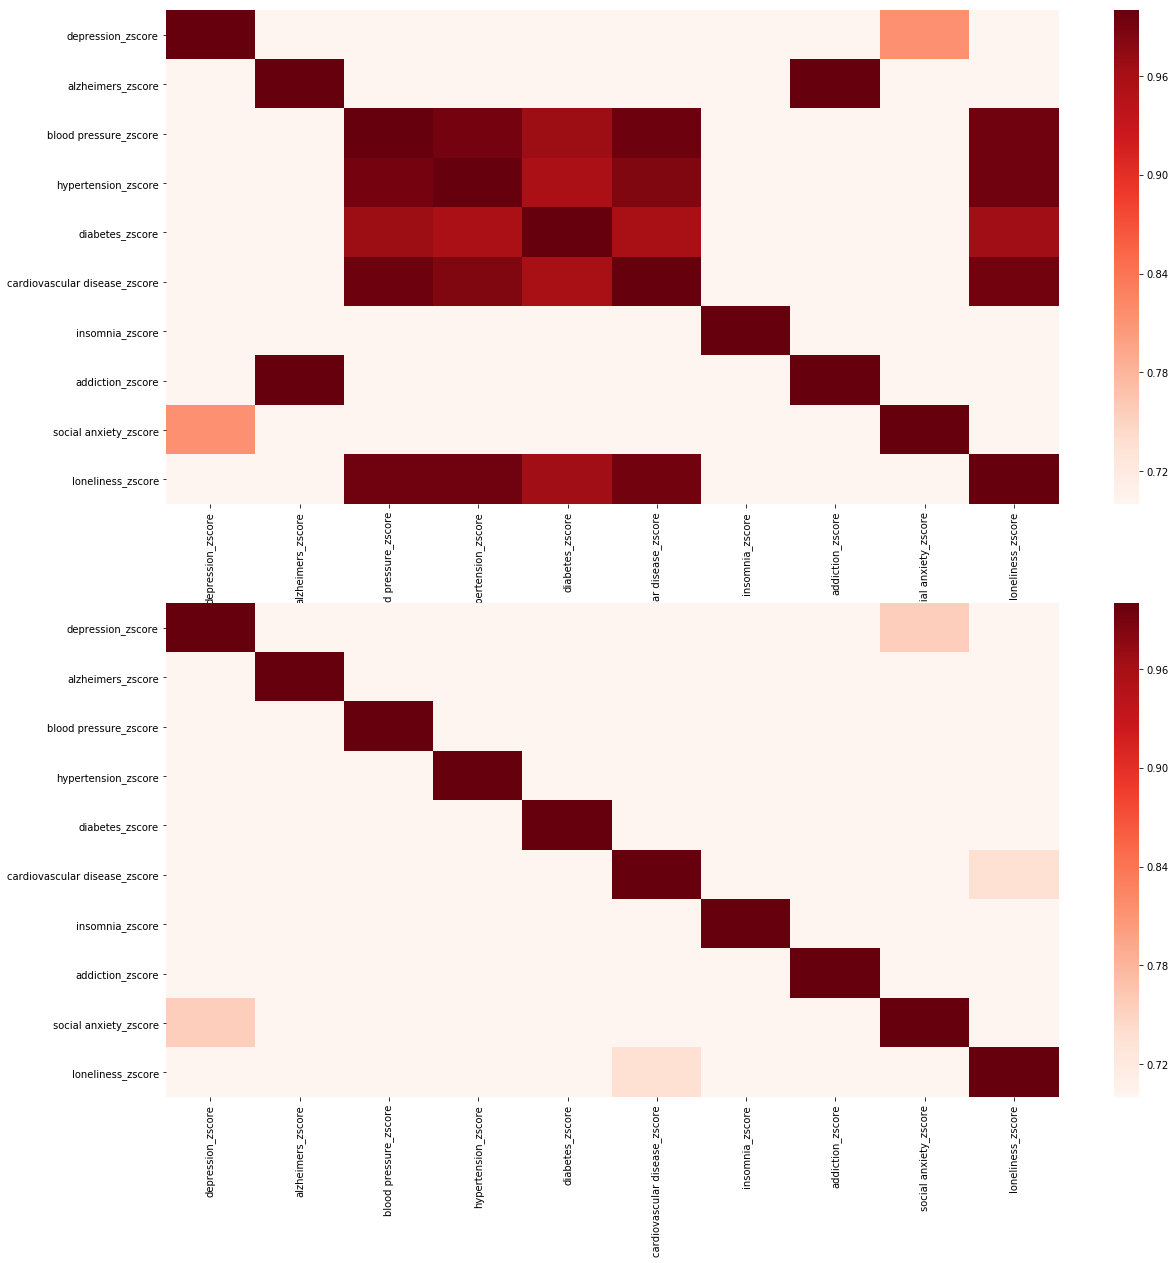

In [24]:
dfOutliers = agg.loc[ np.abs(agg['loneliness_zscore'] -meanScore) > 5*stdScore ]
#dfOutliers = dfOutliers.drop( ['Date','Month','Year','ITEMS'] , axis=1)
dfOutliers = dfOutliers[[s for s in dfOutliers.columns if "zscore"in s]]
dfNominal = agg.loc[ np.abs(agg['loneliness_zscore'] -meanScore) < 5*stdScore ]
dfNominal = dfNominal[[s for s in dfOutliers.columns if "zscore"in s]]
plt.figure(figsize=(20,20))
plt.subplot(2, 1, 1)
sns.heatmap(dfOutliers.corr(), vmin=0.7, vmax=1 , cmap='Reds')
plt.subplot(2, 1, 2)
sns.heatmap(dfNominal.corr(), vmin=0.7, vmax=1 , cmap='Reds')
plt.show()

In [ ]:
geo_data = gpd.GeoDataFrame(proc_data, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = proc_data.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head(100)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6), sharex = True, sharey = True)

geo_data[geo_data['Year'] == 2016].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax1);
geo_data[geo_data['Year'] == 2017].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax2);
geo_data[geo_data['Year'] == 2018].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax3);
